# Ch5: Deep Learning Model
- Deep learning models can be used for supervised or unsupervised learning
- The first step is data preparation
    - Load data from external source
    - Convert to numerical data if necessary
    - Move into tensors and batch
- The next part is model development
    - Design model
    - Train model
    - Test model
- Finally we can deploy the model
- We'll be using the CIFAR-10 dataset
    - 60k small color photos
    - 10 classes
- Also be using the `torchvision` library to handle CV tasks

In [1]:
import torch

# loading dataset
from torchvision.datasets import CIFAR10
from keras.datasets import cifar10
import matplotlib.pyplot as plt

# data transforms
from torchvision import transforms

# batching
from torch.utils.data import DataLoader

# model dev
from torchvision import models
from torch import optim
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# data validation
from torch.utils.data import random_split

## Data Loading

In [2]:
train_data = CIFAR10(
    root="./train/",
    train=True,
    download=True
)
(trainX, trainy), (testX, testy) = cifar10.load_data()

# summarize loaded dataset
print(f'Train: X={trainX.shape}, y={trainy.shape}')
print(f'Test: X={testX.shape}, y={testy.shape}')

Train: X=(50000, 32, 32, 3), y=(50000, 1)
Test: X=(10000, 32, 32, 3), y=(10000, 1)


We can display the first 16 images with `matplotlib`.

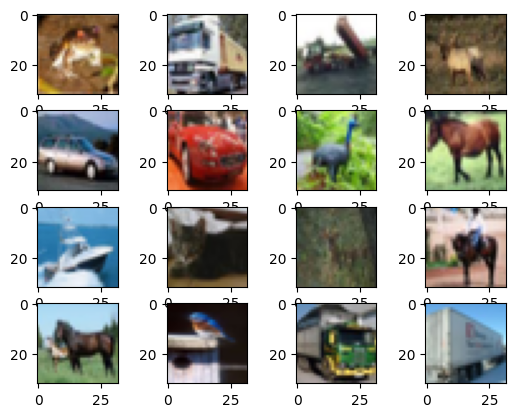

In [3]:
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(trainX[i])
plt.show()

Finally we can examine the training dataset and check the class labels.

In [4]:
print('Train shape:', train_data.data.shape)
print('Classes:', train_data.class_to_idx)

Train shape: (50000, 32, 32, 3)
Classes: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}


We can see there are 50k images. Each image is 32x32 pixels, and each pixel has 3 values that correspond to RGB intensity.

We can also look at the labels for the first 16 photos.

In [5]:
for i in range(16):
  data, label = train_data[i]
  print(f"Picture: {str(i+1)}, photograph:", train_data.classes[label])

Picture: 1, photograph: frog
Picture: 2, photograph: truck
Picture: 3, photograph: truck
Picture: 4, photograph: deer
Picture: 5, photograph: automobile
Picture: 6, photograph: automobile
Picture: 7, photograph: bird
Picture: 8, photograph: horse
Picture: 9, photograph: ship
Picture: 10, photograph: cat
Picture: 11, photograph: deer
Picture: 12, photograph: horse
Picture: 13, photograph: horse
Picture: 14, photograph: bird
Picture: 15, photograph: truck
Picture: 16, photograph: truck


## Data Transforms
PyTorch includes helpful transform functions in the `torchvision` library. The `transforms.Compose` function combines multiple transforms into a single object that can be passed into the dataset loading.

*Note: the normalize values can be calculated by finding the mean/std for each color channel, but they're well-known for this dataset*

In [6]:
train_data_path = "./train/"
train_transforms = transforms.Compose([
    # transforms.Resize(64),  # resize to 64x64 (original is 32x32)
    transforms.ToTensor(),  # convert images to tensors
    transforms.Normalize(   # normalize RGB to ranges 0-1 instead of 0-255
        mean=(0.4914, 0.4822, 0.4465),
        std=(0.2023, 0.1994, 0.2010)
    )
])

train_data = CIFAR10(
    train_data_path,
    train=True,
    download=True,
    transform=train_transforms
)

print(train_data[0])

(tensor([[[-1.2854e+00, -1.5955e+00, -1.4598e+00,  ...,  6.3375e-01,
           5.1744e-01,  4.3990e-01],
         [-2.1189e+00, -2.4291e+00, -2.0801e+00,  ..., -4.4721e-02,
          -1.2226e-01, -6.4106e-02],
         [-1.9444e+00, -2.1189e+00, -1.4792e+00,  ..., -1.4165e-01,
          -1.0288e-01, -3.1611e-01],
         ...,
         [ 1.6030e+00,  1.4673e+00,  1.4091e+00,  ...,  6.7252e-01,
          -1.3435e+00, -1.4017e+00],
         [ 1.0602e+00,  9.2452e-01,  1.1765e+00,  ...,  1.1378e+00,
          -5.4873e-01, -8.2012e-01],
         [ 1.0021e+00,  8.2760e-01,  1.0408e+00,  ...,  1.7581e+00,
           4.9806e-01, -4.4721e-02]],

        [[-1.1989e+00, -1.5136e+00, -1.4742e+00,  ...,  1.7777e-01,
           4.0101e-02,  2.0434e-02],
         [-2.0249e+00, -2.4183e+00, -2.2609e+00,  ..., -6.8757e-01,
          -7.8591e-01, -7.0724e-01],
         [-1.9463e+00, -2.2806e+00, -1.8873e+00,  ..., -7.6624e-01,
          -7.6624e-01, -9.8258e-01],
         ...,
         [ 9.2511e-01,  

We repeat the process for testing dataset, but we don't resize.

In [7]:
test_data_path = "./test/"
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010)
    )
])

test_data = CIFAR10(
    test_data_path,
    train=False,
    download=True,
    transform=train_transforms
)

print(test_data[0])

(tensor([[[ 0.6338,  0.6531,  0.7694,  ...,  0.2267,  0.0134, -0.1804],
         [ 0.5174,  0.4981,  0.6531,  ...,  0.2073, -0.0060, -0.1223],
         [ 0.4981,  0.4981,  0.6338,  ...,  0.2654,  0.0910, -0.1029],
         ...,
         [-1.1109, -1.6149, -1.8281,  ..., -1.6924, -2.1771, -1.6537],
         [-1.2466, -1.4792, -1.7506,  ..., -1.9251, -1.8669, -2.0414],
         [-1.3823, -1.3435, -1.5567,  ..., -1.9638, -1.7700, -2.0220]],

        [[-0.2156, -0.2352, -0.1369,  ..., -0.5499, -0.6286, -0.7466],
         [-0.2156, -0.2549, -0.1762,  ..., -0.5499, -0.6286, -0.6876],
         [-0.2549, -0.2746, -0.2352,  ..., -0.4909, -0.5499, -0.6679],
         ...,
         [ 0.0204, -0.4516, -0.6876,  ..., -0.5106, -1.1596, -0.7466],
         [-0.1369, -0.4122, -0.7466,  ..., -0.8056, -0.8056, -1.1596],
         [-0.3139, -0.3532, -0.6679,  ..., -0.9039, -0.7662, -1.1006]],

        [[-1.2654, -1.3044, -1.2264,  ..., -1.5190, -1.5190, -1.5776],
         [-1.2264, -1.4410, -1.3434,  ..., -

## Data Batching
- We use data loaders to feed data from dataset to NN
- PyTorch uses `torch.utils.data.DataLoader`
    - Represents a Python iterable for the datasets
    Supports lots of useful operations like batching
- NNs train best with batches
    - More efficient training
    - `DataLoader` has a param called `batch_size`
- We also have the `shuffle` param
    - Returns a random batch each time
    - We want this to be false for test data in order to get consistent test results

In [8]:
BATCH_SIZE=16
NUM_WORKERS=2

training_data_loader = DataLoader(
    train_data,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)
test_data_loader = DataLoader(
    test_data,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

## Model Development & Training
First we create our own custom neural network.

In [9]:
class Net(nn.Module):
    # NN layers
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

Next we instantiate the model.

In [10]:
net = Net()

# loss function & optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

Finally, we can start training our NN.

In [11]:
NUM_EPOCHS=10

for epoch in range(NUM_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(training_data_loader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print stats
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.994
[2,  2000] loss: 1.473
[3,  2000] loss: 1.317
[4,  2000] loss: 1.221
[5,  2000] loss: 1.139
[6,  2000] loss: 1.084
[7,  2000] loss: 1.025
[8,  2000] loss: 0.977
[9,  2000] loss: 0.929
[10,  2000] loss: 0.894
Finished Training


## Validation & Testing
We can use PyTorch's `random_split` to create a validation set from our training data. Then we update our loaders for training and validation set.

In [12]:
train_set, val_set = random_split(train_data,[40000, 10000])

trainloader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

valloader = torch.utils.data.DataLoader(
    val_set,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True
)

testloader = test_data_loader

Then we update the code to toggle the mode's training and evaluation mode to separate training and validation metrics. We can use `model.train()` and `model.eval()`.

In [13]:
for epoch in range(NUM_EPOCHS):
    # training mode
    net.train()

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # evaluation mode
    net.eval()
    validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(trainloader)}, Validation Loss: {validation_loss / len(valloader)}, Validation Accuracy: {100 * correct / total}%')

Epoch 1, Training Loss: 0.8631706004858017, Validation Loss: 1.0866426290988922, Validation Accuracy: 62.81%
Epoch 2, Training Loss: 0.8243514821946621, Validation Loss: 1.076660178565979, Validation Accuracy: 62.92%
Epoch 3, Training Loss: 0.7863950597643852, Validation Loss: 1.0944114718437195, Validation Accuracy: 63.22%
Epoch 4, Training Loss: 0.7579533878445626, Validation Loss: 1.1112742290019988, Validation Accuracy: 63.56%
Epoch 5, Training Loss: 0.7237266716361046, Validation Loss: 1.1499579110622407, Validation Accuracy: 62.71%
Epoch 6, Training Loss: 0.7003396515130996, Validation Loss: 1.1659048837900161, Validation Accuracy: 62.65%
Epoch 7, Training Loss: 0.6684427716553211, Validation Loss: 1.1967286870956422, Validation Accuracy: 62.62%
Epoch 8, Training Loss: 0.6460280418157578, Validation Loss: 1.2767927038669586, Validation Accuracy: 60.97%
Epoch 9, Training Loss: 0.6184262776702643, Validation Loss: 1.3029716220617293, Validation Accuracy: 61.81%
Epoch 10, Training L